In [1]:
import os, time, itertools, imageio, pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

In [2]:
def lrelu(x, th=0.2):
    return tf.maximum(th * x, x)

def generator(x, y, isTrain=True, reuse=False):
    
    with tf.variable_scope('generator', reuse=reuse):
        w_init = tf.contrib.layers.xavier_initializer()

        g_input = tf.concat([x, y], 1)
        fc1 = tf.nn.relu(tf.layers.dense(g_input, 128, kernel_initializer=w_init))
        fc2 = tf.layers.dense(fc1, 784, kernel_initializer=w_init)
        generated_outputs = tf.nn.tanh(fc2)

        return generated_outputs

def discriminator(x, isTrain=True, reuse=False):
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        w_init = tf.contrib.layers.xavier_initializer()

        fc1 = lrelu(tf.layers.dense(x, 128, kernel_initializer=w_init))
        fc2 = tf.layers.dense(fc1, 1, kernel_initializer=w_init)
        discrminator_outputs = tf.nn.sigmoid(fc2)
                        
        return discrminator_outputs,fc2, fc1

def classifier(x,isTrain=True,reuse=False):
    
    with tf.variable_scope("classifier", reuse=reuse):
        w_init = tf.contrib.layers.xavier_initializer()
        
        fc1 = tf.nn.relu(tf.layers.dense(x, 128, kernel_initializer=w_init))
        fc2 = tf.layers.dense(fc1, n_classes, kernel_initializer=w_init)
        outputs = tf.nn.softmax(fc2)

        return outputs, fc2


In [3]:
x = tf.placeholder(tf.float32, shape=(None, 784))
y = tf.placeholder(tf.float32, shape=(None, 10))
z = tf.placeholder(tf.float32, shape=(None, 100))
isTrain = tf.placeholder(dtype=tf.bool)

In [4]:
batch_size = 100
lr = 0.0002
train_epoch = 100
n_classes =10
supervised = False

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
train_set = (mnist.train.images - 0.5) / 0.5
train_label = mnist.train.labels


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [5]:
onehot = np.eye(10)

fixed_z_ = np.random.uniform(-1, 1, (25, 100))
random_y = np.random.choice(n_classes, 25)
fixed_y_ = onehot[random_y.astype(np.int32)].squeeze()

def show_result(num_epoch):
    test_images = sess.run(G_z, {z: fixed_z_, y: fixed_y_, isTrain: False})


    size_figure_grid = 5
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for k in range(size_figure_grid*size_figure_grid):
        i = k // size_figure_grid
        j = k % size_figure_grid
        ax[i, j].cla()
        ax[i, j].imshow(np.reshape(test_images[k], (28, 28)), cmap='gray')

    label = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha='center')

    plt.show()

In [6]:
G_z = generator(z, y, isTrain)
D_real, D_real_logits, input_to_classifier_logits_real = discriminator(x,isTrain)
D_fake, D_fake_logits, input_to_classifier_logits_fake = discriminator(G_z,isTrain, reuse=True)
code_fake, code_logits_fake = classifier(G_z,isTrain)


D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_real_logits, 
                                                                     labels=tf.ones([batch_size, 1])))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits,
                                                                     labels=tf.zeros([batch_size, 1])))
D_loss = D_loss_real + D_loss_fake

G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, 
                                                                labels=tf.ones([batch_size, 1])))

q_disc_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=code_logits_fake, 
                                                                     labels=y))

Q_loss = q_disc_loss

In [7]:
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator')
Q_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'classifier')

D_solver = tf.train.AdamOptimizer(learning_rate=1e-3,beta1=0.5).minimize(D_loss, var_list=D_vars)
G_solver = tf.train.AdamOptimizer(learning_rate=1e-3,beta1=0.5).minimize(G_loss, var_list=G_vars)
Q_solver = tf.train.AdamOptimizer(learning_rate=1e-3,beta1=0.5).minimize(Q_loss, var_list=G_vars+Q_vars)

In [8]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

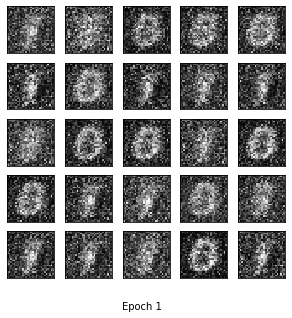

Iter: 0
D loss: 1.121
G_loss: 2.483
Q_loss: 0.006149



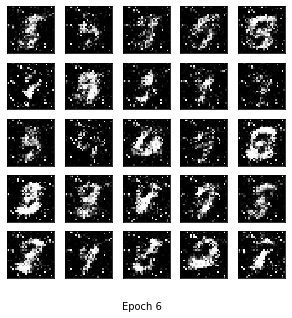

Iter: 5
D loss: 1.318
G_loss: 0.8787
Q_loss: 0.01397



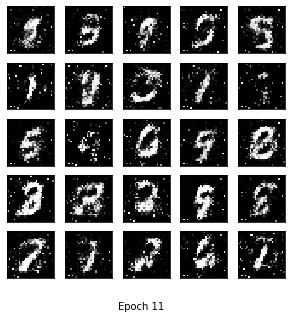

Iter: 10
D loss: 1.447
G_loss: 0.624
Q_loss: 0.05551



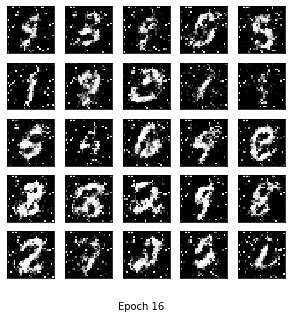

Iter: 15
D loss: 0.7177
G_loss: 1.976
Q_loss: 0.005136



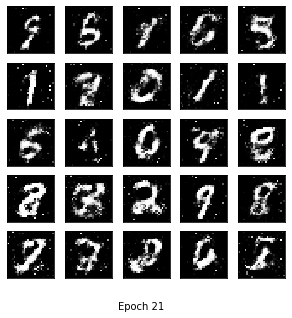

Iter: 20
D loss: 1.31
G_loss: 0.6535
Q_loss: 0.0005524



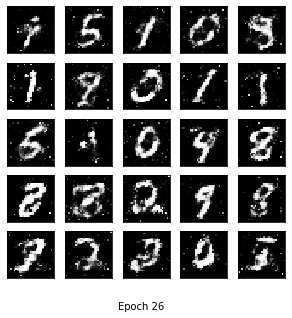

Iter: 25
D loss: 1.078
G_loss: 0.9988
Q_loss: 0.01279



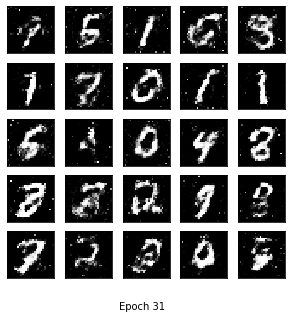

Iter: 30
D loss: 1.214
G_loss: 0.9235
Q_loss: 0.009265



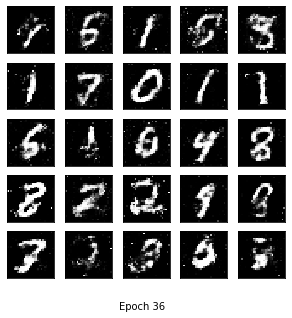

Iter: 35
D loss: 1.099
G_loss: 1.138
Q_loss: 0.004626



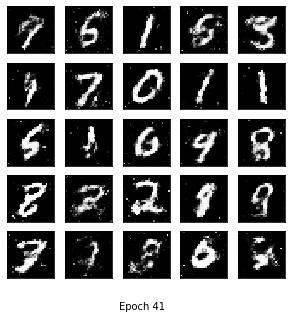

Iter: 40
D loss: 1.086
G_loss: 1.3
Q_loss: 0.0001622



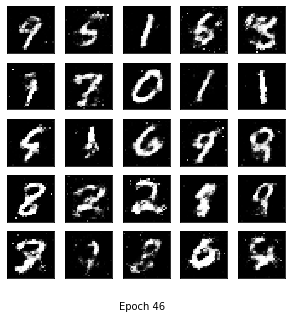

Iter: 45
D loss: 1.172
G_loss: 0.963
Q_loss: 0.000233



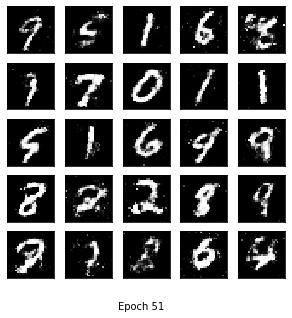

Iter: 50
D loss: 1.098
G_loss: 0.9763
Q_loss: 8.116e-05



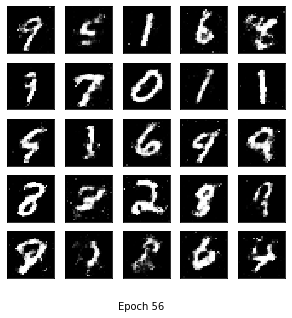

Iter: 55
D loss: 1.098
G_loss: 0.7973
Q_loss: 0.03129



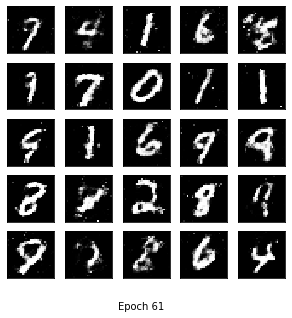

Iter: 60
D loss: 1.046
G_loss: 1.06
Q_loss: 8.394e-06



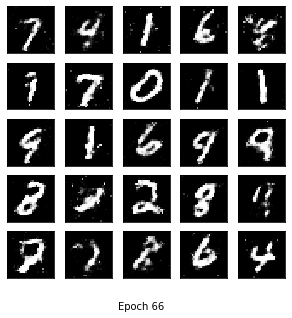

Iter: 65
D loss: 1.181
G_loss: 0.981
Q_loss: 0.004742



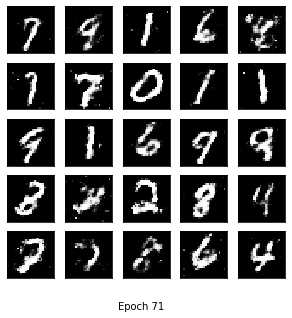

Iter: 70
D loss: 1.062
G_loss: 1.108
Q_loss: 0.0007568



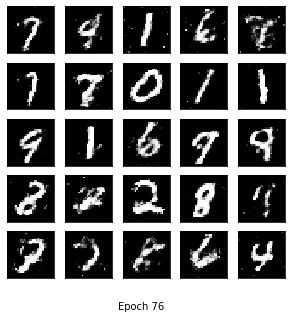

Iter: 75
D loss: 1.201
G_loss: 1.015
Q_loss: 0.0001247



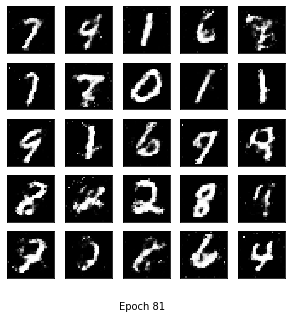

Iter: 80
D loss: 1.015
G_loss: 1.078
Q_loss: 1.351e-05



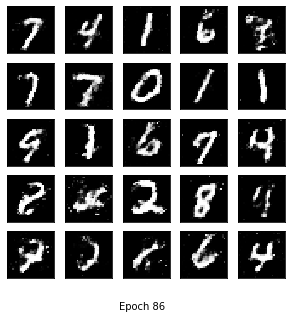

Iter: 85
D loss: 1.154
G_loss: 0.9523
Q_loss: 9.656e-08



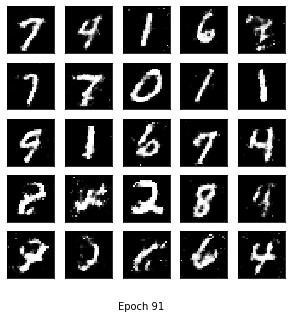

Iter: 90
D loss: 1.369
G_loss: 0.5636
Q_loss: 1.975e-05



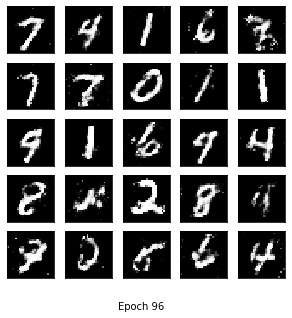

Iter: 95
D loss: 1.097
G_loss: 1.062
Q_loss: 8.52e-05



In [9]:
for it in range(100):
        
    for iter in range(mnist.train.num_examples // batch_size):

        x_ = train_set[iter*batch_size:(iter + 1)*batch_size]
        
        if supervised:
            y_ = train_label[iter*batch_size:(iter + 1)*batch_size]
        else:
            y_ = np.random.multinomial(1,n_classes * [float(1.0 / n_classes)],size=[batch_size])
            
        z_ = np.random.uniform(-1, 1, (batch_size, 100))
        
        _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={x: x_, y: y_, z: z_, isTrain: True})
    
        _, G_loss_curr,_, Q_loss_curr = sess.run([G_solver, G_loss,Q_solver,Q_loss], 
                                                 feed_dict={y: y_, z: z_,x: x_, isTrain: True})
        
    if it % 5 == 0 :
        
        show_result((it + 1))
        print('Iter: {}'.format(it))
        print('D loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        print('Q_loss: {:.4}'.format(Q_loss_curr))
        print()

In [34]:
condition = [2]*25 
condition = np.array(condition)

test_z = np.random.uniform(-1, 1, (25, 100))
fixed_y = onehot[condition.astype(np.int32)].squeeze()

def show_result_test():
    test_images,test_d_class_outputs = sess.run([G_z,code_logits_fake], {z: test_z, y: fixed_y, isTrain: False})
    
    out = test_d_class_outputs.argmax(axis=1)
    print(out)


    size_figure_grid = 5
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for k in range(size_figure_grid*size_figure_grid):
        i = k // size_figure_grid
        j = k % size_figure_grid
        ax[i, j].cla()
        ax[i, j].imshow(np.reshape(test_images[k], (28, 28)), cmap='gray')

    plt.show()

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


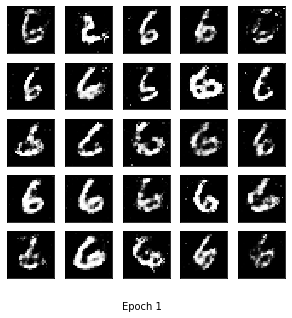

In [35]:
show_result_test()

Note: The order may not be right(here 2 means 6) but the semantic relationship is right

Note 1: I only trained for 100 epochs with a simple architecture so results may not that good 
      but if we train more with better architectures , the results will be impressive 